# Quantum Teleportation

This notebook demonstrates quantum teleportation. We first use Qiskit's built-in simulators to test our quantum circuit, and then try it out on a real quantum computer.

## Contents

1. [Overview](#overview)    
2. [The Quantum Teleportation Protocol](#how)       
3. [Simulating the Teleportation Protocol](#simulating)   
    3.1 [How will we Test this Result on a Real Quantum Computer?](#testing)   
    3.2 [Using the Simulated Statevector](#simulating-sv)     
    3.3 [Using the Simulated Counts](#simulating-fc)  
4. [Understanding Quantum Teleportation](#understanding-qt)
5. [Teleportation on a Real Quantum Computer](#real_qc)    
    5.1 [IBM hardware and Deferred Measurement](#deferred-measurement)    
    5.2 [Executing](#executing)    
6. [References](#references)



## 1. Overview <a id='overview'></a>

Alice wants to send quantum information to Bob. Specifically, suppose she wants to send the qubit state
$\vert\psi\rangle = \alpha\vert0\rangle + \beta\vert1\rangle$. 
This entails passing on information about $\alpha$ and $\beta$ to Bob.

There exists a theorem in quantum mechanics which states that you cannot simply make an exact copy of an unknown quantum state. This is known as the no-cloning theorem. As a result of this we can see that Alice can't simply generate a copy of $\vert\psi\rangle$ and give the copy to Bob. We can only copy classical states (not superpositions).

However, by taking advantage of two classical bits and an entangled qubit pair, Alice can transfer her state $\vert\psi\rangle$ to Bob. We call this teleportation because, at the end, Bob will have $\vert\psi\rangle$ and Alice won't anymore.

## 2. The Quantum Teleportation Protocol <a id='how'></a>
To transfer a quantum bit, Alice and Bob must use a third party (Telamon) to send them an entangled qubit pair. Alice then performs some operations on her qubit, sends the results to Bob over a classical communication channel, and Bob then performs some operations on his end to receive Alice’s qubit.

![teleportation_doodle](images/tele1.jpg)

We will describe the steps on a quantum circuit below. Here, no qubits are actually ‘sent’, you’ll just have to imagine that part!

First we set up our session:

In [1]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile, assemble
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
#from qiskit.extensions import Initialize
from qiskit.circuit.library import Initialize
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector

None


and create our quantum circuit:

In [2]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers

qr = QuantumRegister(3, name="q")    # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

#### Step 1
A third party, Telamon, creates an entangled pair of qubits and gives one to Bob and one to Alice.

The pair Telamon creates is a special pair called a Bell pair. In quantum circuit language, the way to create a Bell pair between two qubits is to first transfer one of them to the X-basis ($|+\rangle$ and $|-\rangle$) using a Hadamard gate, and then to apply a CNOT gate onto the other qubit controlled by the one in the X-basis. 

In [3]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

In [4]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
# In our case, Telamon entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw()

q_0: ──────────
       ┌───┐     
  q_1: ┤ H ├──■──
       └───┘┌─┴─┐
  q_2: ─────┤ X ├
            └───┘
crz: 1/══════════
                 
crx: 1/══════════

Let's say Alice owns $q_1$ and Bob owns $q_2$ after they part ways.

#### Step 2 

Alice applies a CNOT gate to $q_1$, controlled by $\vert\psi\rangle$ (the qubit she is trying to send Bob). Then Alice applies a Hadamard gate to $|\psi\rangle$. In our quantum circuit, the qubit ($|\psi\rangle$) Alice is trying to send is $q_0$:

In [5]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [6]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

░      ┌───┐
  q_0: ───────────░───■──┤ H ├
       ┌───┐      ░ ┌─┴─┐└───┘
  q_1: ┤ H ├──■───░─┤ X ├─────
       └───┘┌─┴─┐ ░ └───┘     
  q_2: ─────┤ X ├─░───────────
            └───┘ ░           
crz: 1/═══════════════════════
                              
crx: 1/═══════════════════════

#### Step 3

Next, Alice applies a measurement to both qubits that she owns, $q_1$ and $\vert\psi\rangle$, and stores this result in two classical bits. She then sends these two bits to Bob.

In [7]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

In [8]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

None
None


░      ┌───┐ ░ ┌─┐   
  q_0: ───────────░───■──┤ H ├─░─┤M├───
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘
  q_2: ─────┤ X ├─░────────────░──╫──╫─
            └───┘ ░            ░  ║  ║ 
crz: 1/═══════════════════════════╩══╬═
                                  0  ║ 
crx: 1/══════════════════════════════╩═
                                     0

#### Step 4

Bob, who already has the qubit $q_2$, then applies the following gates depending on the state of the classical bits:

00 $\rightarrow$ Do nothing

01 $\rightarrow$ Apply $X$ gate

10 $\rightarrow$ Apply $Z$ gate

11 $\rightarrow$ Apply $ZX$ gate

(*Note that this transfer of information is purely classical*.)

In [9]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

In [10]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)

## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

None
None


░      ┌───┐ ░ ┌─┐    ░               
  q_0: ───────────░───■──┤ H ├─░─┤M├────░───────────────
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
  q_2: ─────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─
            └───┘ ░            ░  ║  ║  ░  └─╥─┘  └─╥─┘ 
                                  ║  ║       ║   ┌──╨──┐
crz: 1/═══════════════════════════╩══╬═══════╬═══╡ 0x1 ╞
                                  0  ║    ┌──╨──┐└─────┘
crx: 1/══════════════════════════════╩════╡ 0x1 ╞═══════
                                     0    └─────┘

And voila! At the end of this protocol, Alice's qubit has now teleported to Bob.

## 3. Simulating the Teleportation Protocol <a id='simulating'></a>

### 3.1 How Will We Test the Protocol on a Quantum Computer? <a id='testing'></a>

In this notebook, we will initialize Alice's qubit in a random state $\vert\psi\rangle$ (`psi`). This state will be created using an `Initialize` gate on $|q_0\rangle$. In this chapter we use the function `random_statevector` to choose `psi` for us, but feel free to set `psi` to any qubit state you want.

<IPython.core.display.Latex object>

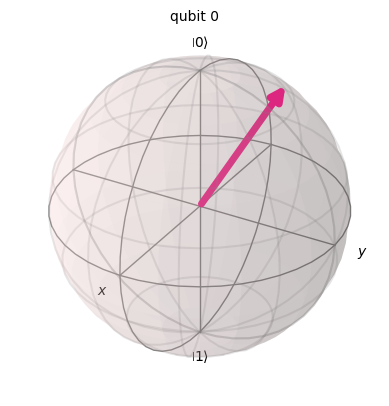

In [11]:
# Create random 1-qubit state
psi = random_statevector(2)

# Display it nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

Let's create our initialization instruction to create $|\psi\rangle$ from the state $|0\rangle$:

In [12]:
init_gate = Initialize(psi)
init_gate.label = "init"

(`Initialize` is technically not a gate since it contains a reset operation, and so is not reversible. We call it an 'instruction' instead). If the quantum teleportation circuit works, then at the end of the circuit the qubit $|q_2\rangle$ will be in this state. We will check this using the statevector simulator.

### 3.2 Density Matrix Simulation and Deferred Measurement <a id='deferred-measurement'></a>

<!-- The density matrix simulator does not support instructions after measurements, meaning we cannot run the quantum teleportation in its current form. Fortunately, this does not limit our ability to perform any computations due to the _deferred measurement principle_ discussed in chapter 4.4 of [1]. The principle states that any measurement can be postponed until the end of the circuit, i.e. we can move all the measurements to the end, and we should see the same results.
 -->
![deferred_measurement_gates](images/defer_measurement.svg)

Any benefits of measuring early are hardware related: If we can measure early, we may be able to reuse qubits, or reduce the amount of time our qubits are in their fragile superposition. In this example, the early measurement in quantum teleportation would have allowed us to transmit a qubit state without a direct quantum communication channel.

While moving the gates allows us to demonstrate the "teleportation" circuit on density matrix simulator, it should be noted that the benefit of the teleportation process (transferring quantum states via classical channels) is lost.

In [13]:
## SETUP
# qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
# crz = ClassicalRegister(1, name="crz") # and 2 classical registers
# crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(3, 3)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

# ## STEP 3
# # Alice then sends her classical bits to Bob
# measure_and_send(qc, 0, 1)

# ## STEP 4
# # Bob decodes qubits
# bob_gates(qc, 2, crz, crx)
qc.barrier()
qc.cx(1,2)
qc.cz(0,2)
for i in range(3):
    qc.measure(i,i,basis='Ensemble')
# Display the circuit
qc.draw()

Ensemble
Ensemble
Ensemble


┌────────────────────────────────────────────┐ ░            ░      ┌───┐»
q_0: ┤ init(-0.38896+0.85459j,-0.049203-0.34054j) ├─░────────────░───■──┤ H ├»
     └────────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘»
q_1: ───────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├─────»
                                                    ░ └───┘┌─┴─┐ ░ └───┘     »
q_2: ───────────────────────────────────────────────░──────┤ X ├─░───────────»
                                                    ░      └───┘ ░           »
c: 3/════════════════════════════════════════════════════════════════════════»
                                                                             »
«      ░          ░ ┌─┐ ░  ░     ░  ░     ░ 
«q_0: ─░───────■──░─┤M├─░──░─────░──░─────░─
«      ░       │  ░ └╥┘ ░  ░ ┌─┐ ░  ░     ░ 
«q_1: ─░───■───┼──░──╫──░──░─┤M├─░──░─────░─
«      ░ ┌─┴─┐ │  ░  ║  ░  ░ └╥┘ ░  ░ ┌─┐ ░ 
«q_2: ─░─┤ X ├─■──░──╫──░──░──╫──░──░─┤M├─░─
«      ░ └───┘    ░  ║  ░  ░  ║  ░  ░ └╥┘ ░ 
«c: 3/═══════════════╩════════╩════════╩════
«                    0        1        2

We can see below, using the statevector obtained from the aer simulator, that the state of $|q_2\rangle$ is the same as the state $|\psi\rangle$ we created above, while the states of $|q_0\rangle$ and $|q_1\rangle$ have been collapsed to either $|0\rangle$ or $|1\rangle$. The state $|\psi\rangle$ has been teleported from qubit 0 to qubit 2.

{'000': 0.22039794921875, '001': 0.02960205078125, '010': 0.22039794921875, '011': 0.02960205078125, '100': 0.22039794921875, '101': 0.02960205078125, '110': 0.22039794921875, '111': 0.02960205078125}


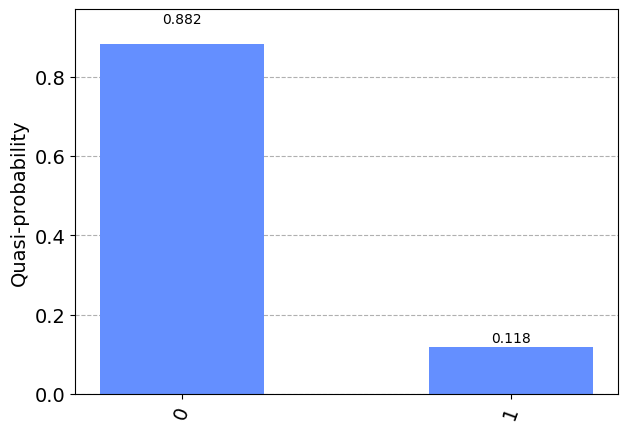

In [14]:
backend = Aer.get_backend('dm_simulator')
#run = execute(qc,backend,shots=1)
qc = transpile(qc, backend=backend)
run = backend.run(qc)
result = run.result()
answer = result.results[0].data.ensemble_probability
print(answer)

for state in answer:
    if(answer[state] < 0.0001):
        answer[state]=0
probs = {'0':0, '1':0}
for state in answer:
    if(state[2] == '0'):
        probs['0'] += answer[state]
probs['1'] = 1 - probs['0']
#Plotting probabilities of measuring last qubit as 0 or 1
plot_histogram(probs)

## 4. Understanding Quantum Teleportation <a id="understanding-qt"></a>

As you have worked with the Quantum Teleportation's implementation, it is time to understand the mathematics behind the protocol.

#### Step 1

Quantum Teleportation begins with the fact that Alice needs to transmit $|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$ (a random qubit) to Bob. She doesn't know the state of the qubit. For this, Alice and Bob take the help of a third party (Telamon). Telamon prepares a pair of entangled qubits for Alice and Bob. The entangled qubits could be written in Dirac Notation as:

$$ |e \rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle) $$

Alice and Bob each possess one qubit of the entangled pair (denoted as A and B respectively),

$$|e\rangle = \frac{1}{\sqrt{2}} (|0\rangle_A |0\rangle_B + |1\rangle_A |1\rangle_B) $$

This creates a three qubit quantum system where Alice has the first two qubits and Bob the last one.

$$ \begin{align*}
|\psi\rangle \otimes |e\rangle &= \frac{1}{\sqrt{2}} (\alpha |0\rangle \otimes (|00\rangle + |11\rangle) + \beta |1\rangle \otimes (|00\rangle + |11\rangle))\\
&= \frac{1}{\sqrt{2}} (\alpha|000\rangle + \alpha|011\rangle + \beta|100\rangle + \beta|111\rangle) 
\end{align*}$$

#### Step 2

Now according to the protocol Alice applies CNOT gate on her two qubits followed by Hadamard gate on the first qubit. This results in the state:

$$ 
\begin{align*} (H \otimes I \otimes I) (CNOT \otimes I) (|\psi\rangle \otimes |e\rangle)
&=(H \otimes I \otimes I) (CNOT \otimes I) \frac{1}{\sqrt{2}} (\alpha|000\rangle + \alpha|011\rangle + \beta|100\rangle + \beta|111\rangle) \\
&= (H \otimes I \otimes I) \frac{1}{\sqrt{2}} (\alpha|000\rangle + \alpha|011\rangle + \beta|110\rangle + \beta|101\rangle) \\
&= \frac{1}{2}  (\alpha(|000\rangle + |011\rangle + |100\rangle + |111\rangle) + \beta(|010\rangle + |001\rangle - |110\rangle - |101\rangle)) \\
\end{align*}
$$

Which can then be separated and written as: 

$$
\begin{align*}
= \frac{1}{2}(
 & \phantom{+} |00\rangle (\alpha|0\rangle + \beta|1\rangle) \hphantom{\quad )} \\
 & + |01\rangle (\alpha|1\rangle + \beta|0\rangle) \hphantom{\quad )}\\[4pt]
 & + |10\rangle (\alpha|0\rangle - \beta|1\rangle) \hphantom{\quad )}\\[4pt]
 & + |11\rangle (\alpha|1\rangle - \beta|0\rangle) \quad )\\
\end{align*}
$$

#### Step 3

Alice measures the first two qubit (which she owns) and sends them as two classical bits to Bob. The result she obtains is always one of the four standard basis states $|00\rangle, |01\rangle, |10\rangle,$ and $|11\rangle$ with equal probability.  

On the basis of her measurement, Bob's state will be projected to, 
$$ |00\rangle \rightarrow (\alpha|0\rangle + \beta|1\rangle)\\
|01\rangle \rightarrow (\alpha|1\rangle + \beta|0\rangle)\\
|10\rangle \rightarrow (\alpha|0\rangle - \beta|1\rangle)\\
|11\rangle \rightarrow (\alpha|1\rangle - \beta|0\rangle)$$.

#### Step 4

Bob, on receiving the bits from Alice, knows he can obtain the original state $|\psi\rangle$ by applying appropriate transformations on his qubit that was once part of the entangled pair.

The transformations he needs to apply are:

$$
\begin{array}{c c c}
\mbox{Bob's State}                 & \mbox{Bits Received} & \mbox{Gate Applied} \\
(\alpha|0\rangle + \beta|1\rangle) & 00                   & I                   \\
(\alpha|1\rangle + \beta|0\rangle) & 01                   & X                   \\
(\alpha|0\rangle - \beta|1\rangle) & 10                   & Z                   \\
(\alpha|1\rangle - \beta|0\rangle) & 11                   & ZX
\end{array}
$$

After this step Bob will have successfully reconstructed Alice's state.

## 6. References <a id='references'></a>
[1] M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000).

[2] Eleanor Rieffel and Wolfgang Polak, Quantum Computing: a Gentle Introduction (The MIT Press Cambridge England, Massachusetts, 2011).

In [16]:
import tutorial_magics

%qiskit_version_table